# <div style="text-align:center;"> <span style="color:#2E86C1;"> Data Science ML Project </span> </div>
### <div style="text-align:center"> <span style="color:#117A65;"> <strong>Predicting Monthly Rental Prices in Qatar</strong> </span> </div>

# Table of Contents
1. [Loading Libraries](#1--Loading-Libraries)
2. [Loading & Exploring Dataset](#2--Loading-&-Exploring-Dataset)
3. [Feature Engineering](#3--Feature-Engineering)
4. [Dropping Unnecessary Columns](#4--Dropping-Unnecessary-Columns)
5. [Data Visualizations](#5--Data-Visualizations)
6. [Summarizing Dataset](#6--Summarizing-Dataset)
7. [Data Cleaning](#7--Data-Cleaning)
8. [Handeling Missing Values](#8--Handeling-Missing-Values)
9. [Reducing Dimensionality](#9--Reducing-Dimensionality)
10. [ML Modelling](#10--ML-Modelling)
11. [Regression Models](#11--Regression-Models)
12. [Feature Importances](#12--Feature-Importances)
13. [Making Predictions](#13--Making-Predictions)
14. [Exporting Model](#14--Exporting-Model)

## <span style="color:#CA6F1E;">1- Loading Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
from itertools import chain

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from xgboost import XGBRegressor

import pickle
import json

## <span style="color:#CA6F1E;">2- Loading & Exploring Dataset</span>

In [3]:
# loading the dataset
df = pd.read_csv('qatar_rental_properties.csv')
df.head()

,title,price,location,bedrooms,bathrooms,area,property_type,listing_url
0,BRAND NEW 2BDR + MAID | FURNISHED | BILLS INCL...,8500,"Dara, Fox Hills, Lusail",8.0,2.0,120,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
1,"2 BHK IN WAKRA,NO COMMISSION,AUGUST FREE",3800,"Al Wakra Hotel, Al Wakra, Al Wakrah, Al Wakra",2.0,2.0,75,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
2,DEAL OF THE MONTH | FURNISHED 2BR | AL WAAB,6200,"Janayin Al Waab, Al Waab, Doha",2.0,2.0,127,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
3,BILLS INCLUDED | NEW 2BR | HOTEL FACILITIES,10154,"West Bay Villas, West Bay, West Bay, Doha",2.0,2.0,137,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
4,BILLS INCLUDED | BRAND NEW | HOTEL FACILITIES,7846,"Burj Doha, West Bay, West Bay, Doha",1.0,1.0,84,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...


In [5]:
# check the number of rows/obs and columns/features
print(f"The dataset has {df.shape[0]} listings")
print(f"Columns: {list(df.columns)}")

The dataset has 19118 listings
Columns: ['title', 'price', 'location', 'bedrooms', 'bathrooms', 'area', 'property_type', 'listing_url']


## <span style="color:#CA6F1E;">3- Feature Engineering</span>

In [7]:
# Let's extract city and districts from the location column
def extract_city_districts(location):
    """
    Extract city and district from string location.

    Args: string location

    Returns a tuple containing (district_name, city_name)
    """
    # make sure location is not null or empty
    if location:
        # split the location string by commas into a list
        splitted_location = location.split(',')
        # make sure the list has elements
        if splitted_location:
            city = splitted_location[-1].strip() if len(splitted_location) >= 1 else "Unknown"
            district = splitted_location[-2].strip() if len(splitted_location) >= 2 else "Unknown"
            return district, city
        else:
            return "Unknown", "Unknown"

In [9]:
# apply the function to the location column
df[['district', 'city']] = df["location"].apply(extract_city_districts).apply(pd.Series)
df.head()

,title,price,location,bedrooms,bathrooms,area,property_type,listing_url,district,city
0,BRAND NEW 2BDR + MAID | FURNISHED | BILLS INCL...,8500,"Dara, Fox Hills, Lusail",8.0,2.0,120,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Fox Hills,Lusail
1,"2 BHK IN WAKRA,NO COMMISSION,AUGUST FREE",3800,"Al Wakra Hotel, Al Wakra, Al Wakrah, Al Wakra",2.0,2.0,75,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Al Wakrah,Al Wakra
2,DEAL OF THE MONTH | FURNISHED 2BR | AL WAAB,6200,"Janayin Al Waab, Al Waab, Doha",2.0,2.0,127,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Al Waab,Doha
3,BILLS INCLUDED | NEW 2BR | HOTEL FACILITIES,10154,"West Bay Villas, West Bay, West Bay, Doha",2.0,2.0,137,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,West Bay,Doha
4,BILLS INCLUDED | BRAND NEW | HOTEL FACILITIES,7846,"Burj Doha, West Bay, West Bay, Doha",1.0,1.0,84,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,West Bay,Doha


In [11]:
# Checking the unique cities in this data
print(f"*** Unique Cities: {df.city.unique()}\n")
print(f"*** The number of unique cities is {df.city.nunique()}")

*** Unique Cities: ['Lusail' 'Al Wakra' 'Doha' 'Al Khor' 'Umm Salal Mohammed' 'Al Shamal'
 'Al Daayen' 'Dukhan Highway']

*** The number of unique cities is 8


In [13]:
print(f"Unique Property Types: {df.property_type.unique()}")

Unique Property Types: ['Apartment' 'Studio' 'Villa' 'Townhouse']


## <span style="color:#CA6F1E;">4- Dropping Unnecessary Columns</span>

In [15]:
# Let's drop uncessary columns
df = df.drop(['title', 'location', 'listing_url'], axis=1)
df.head()

,price,bedrooms,bathrooms,area,property_type,district,city
0,8500,8.0,2.0,120,Apartment,Fox Hills,Lusail
1,3800,2.0,2.0,75,Apartment,Al Wakrah,Al Wakra
2,6200,2.0,2.0,127,Apartment,Al Waab,Doha
3,10154,2.0,2.0,137,Apartment,West Bay,Doha
4,7846,1.0,1.0,84,Apartment,West Bay,Doha


## <span style="color:#CA6F1E;">5- Data Visualizations</span>

In [17]:
def plot_pie_chart(df, feature, percentThreshold=5):
    """
    A function that plot a pie chart showing the distribution of categorical features

    Args: dataframe, name of categorical feature and percentThreshold that control labeling appear on the slices on the pie chart
    """
    
    # Count category occurrences
    counts = df[feature].value_counts().reset_index()
    counts.columns = [feature, 'count']
    
    # Compute percentage
    counts['percent'] = counts['count'] / counts['count'].sum() * 100

    # Create the pie chart
    fig = px.pie(
        counts,
        names=feature,
        values='count',
        title=f'Breakdown of Rental Properties by {re.sub(r'[^A-Za-z]', ' ', feature).strip().title()}',
    )

    # Center the title
    fig.update_layout(title_x=0.5)

    # Conditionally show labels only if percent > threshold
    fig.update_traces(
        text=[
            f"{row[feature]} ({row['percent']:.1f}%)" if row['percent'] > percentThreshold else ""
            for _, row in counts.iterrows()
        ],
        textinfo='text',                # Only show our custom text
        texttemplate='%{percent}',
        textposition='inside',          # Keep labels inside slices
        hovertemplate='%{label}: %{value} (%{percent})'  # Always show on hover
    )

    fig.show()

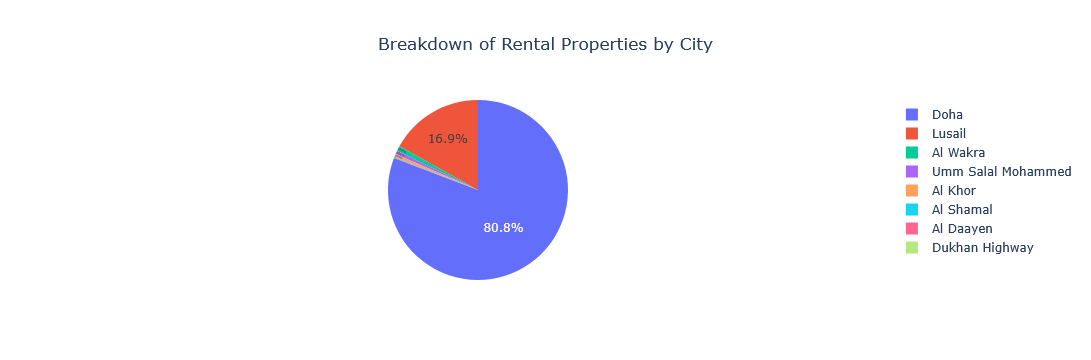

In [19]:
# Check the distribution by the city
plot_pie_chart(df=df, feature='city')

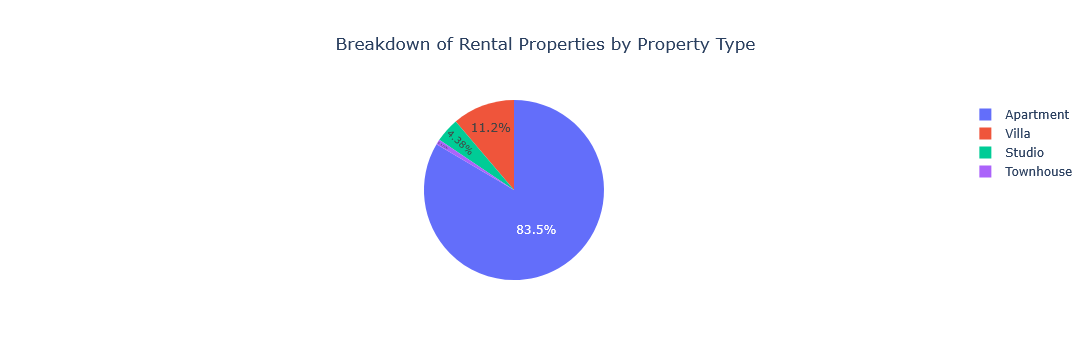

In [21]:
# Check the distribution by property type
plot_pie_chart(df=df, feature='property_type')

* The majority of the real esate listings are located in Doha with a percentage of 80%.
* Nearly 4 out of five listings are of apartment type and villa comes second making up just about 10% of the listings which is nearly double the proportions of studios in the dataset.

## <span style="color:#CA6F1E;">6- Summarizing Dataset</span>

In [23]:
df.describe()

,price,bedrooms,bathrooms,area
count,1.911800e+04,19103.000000,19106.000000,1.911800e+04
mean,1.178707e+04,2.355599,2.916885,2.364179e+02
std,7.635231e+04,1.713842,2.374139,8.713371e+03
min,1.500000e+03,1.000000,1.000000,1.000000e+00
25%,6.500000e+03,1.000000,1.000000,1.000000e+02
50%,8.500000e+03,2.000000,2.000000,1.250000e+02
75%,1.150000e+04,3.000000,3.000000,1.710000e+02
max,6.000566e+06,10.000000,10.000000,1.204500e+06


* The maximum rental price is about 6 million QAR which is huge for one month rent.
* The maximum size of a rental property is about 1.2 million sqm which is about the size of three shopping malls (assuming each is about 400K sqm).
* These numbers do not make any sense and hence we need to clean our dataset before feeding it to a model to learn patterns and make predicitons.

## <span style="color:#CA6F1E;">7- Data Cleaning</span>

In [25]:
# Let's create a function to see if any of our cleaning steps is biased against particular category
def return_category_percent_dist(df, feature):
    """
    Calculate the percentage distribution of each category in a specified column.

    Returns:
        pd.Series representing the percentage of each category.
    """
    counts = df.groupby(feature).size()
    percents = (counts / counts.sum() * 100).round(2)
    return percents
    
def check_distribution_removed_indices(df, indices, feature):
    """
    The function calculates percentage of removed categories as a result of applying cleaning step and compares to its percentage in the entire 
    dataset.
    """
    # extract subset of removed rows
    df_excluded = df.loc[indices]
    # calculate the category percentage for this subset
    percents = return_category_percent_dist(df_excluded, feature)
    percents = percents.to_frame()
    percents.columns = ['percent%_removed']
    # calculate the category percentage for the entire dataset
    percent_total = return_category_percent_dist(df=df, feature=feature)
    # Align indices and total percentage column
    percent_total = percent_total[percent_total.index.isin(percents.index)]
    percent_total.index = percents.index
    percents['percent%_total'] = percent_total
    return percents.sort_values(by='percent%_removed', ascending=False)

#### __Price/Area (QAR/sqm)__

In [27]:
# Let's create feature that we can use to clean the area and price columns
df['price_per_m2'] = df['price'] / df['area']
df.head()

,price,bedrooms,bathrooms,area,property_type,district,city,price_per_m2
0,8500,8.0,2.0,120,Apartment,Fox Hills,Lusail,70.833333
1,3800,2.0,2.0,75,Apartment,Al Wakrah,Al Wakra,50.666667
2,6200,2.0,2.0,127,Apartment,Al Waab,Doha,48.818898
3,10154,2.0,2.0,137,Apartment,West Bay,Doha,74.116788
4,7846,1.0,1.0,84,Apartment,West Bay,Doha,93.404762


In [29]:
# now we group our data by property_type, city and district and remove price/m2 outliers within each group
# Let's create a function to do just that
def find_outlier_indices(group, feature):
    """
    Removes outliers from each group based on a numerical feature by applying IQR rule.
    """
    if len(group) < 5:
        return group.index
    lower_q = group[feature].quantile(0.25)
    upper_q = group[feature].quantile(0.75)
    IQR = upper_q - lower_q
    lower_bound = lower_q - 1.5 * IQR
    uppder_bound = upper_q + 1.5 * IQR
    # find outlier rows
    mask = (group[feature] < lower_bound) | (group[feature] > uppder_bound)
    return group[mask].index

In [31]:
outlier_indices = df.groupby(['property_type', 'district', 'city']).apply(
    lambda g: find_outlier_indices(group=g, feature='price_per_m2'), include_groups=False).tolist()
flat_indices = list(chain.from_iterable(outlier_indices))
# drop outlier indices and assign the result to an intermediary dataframe
df_cl1 = df.drop(flat_indices)

In [33]:
# checking the number of removed rows/obs 
print(f"The original data had {df.shape[0]} listings")
print(f"After cleaning we have {df_cl1.shape[0]} listings")
if (df.shape[0] - df_cl1.shape[0]) == len(flat_indices):
    print(f'{len(flat_indices)} listings were removed')

The original data had 19118 listings
After cleaning we have 18277 listings
841 listings were removed


In [35]:
# Let's check the distribution of removed property types and compare it to their proportion in the entire dataset
check_distribution_removed_indices(df=df, indices=flat_indices, feature='property_type')

,percent%_removed,percent%_total
property_type,,
Apartment,63.14,83.49
Villa,24.61,11.21
Studio,9.99,4.38
Townhouse,2.26,0.92


In [37]:
# Let's check the distribution of removed cities and compare it to their proportion in the entire dataset
check_distribution_removed_indices(df=df, indices=flat_indices, feature='city')

,percent%_removed,percent%_total
city,,
Doha,77.88,80.80
Lusail,14.51,16.90
Umm Salal Mohammed,2.38,0.63
Al Wakra,1.66,0.90
Al Khor,1.55,0.55
Al Daayen,1.19,0.07
Al Shamal,0.71,0.15
Dukhan Highway,0.12,0.01


Before moving let's drop [__price/m2__] feature since we no long need it and it will cause data leakage in our model.

In [39]:
df_cl1 = df_cl1.drop('price_per_m2', axis=1)

#### __Area__

In [41]:
# Let's remove outliers in the area column as well
extreme_area_indices =  df_cl1.groupby(['property_type', 'district', 'city']).apply(
    lambda g: find_outlier_indices(group=g, feature='area'), include_groups=False).tolist()
flat_extreme_area_indices = list(chain.from_iterable(extreme_area_indices))
df_cl2 = df_cl1.drop(flat_extreme_area_indices)

In [43]:
print(f"Before removing extreme area, the dataset had {df_cl1.shape[0]} listings")
print(f"After removing extreme areas we have {df_cl2.shape[0]} listings")
print(f'{len(flat_extreme_area_indices)} listings were removed')

Before removing extreme area, the dataset had 18277 listings
After removing extreme areas we have 17445 listings
832 listings were removed


In [45]:
check_distribution_removed_indices(df=df_cl1, indices=flat_extreme_area_indices, feature='property_type')

,percent%_removed,percent%_total
property_type,,
Apartment,81.01,84.42
Villa,15.87,10.60
Studio,2.88,4.13
Townhouse,0.24,0.85


In [47]:
check_distribution_removed_indices(df=df_cl1, indices=flat_extreme_area_indices, feature='city')

,percent%_removed,percent%_total
city,,
Doha,87.50,80.93
Lusail,7.81,17.01
Al Khor,2.16,0.50
Umm Salal Mohammed,0.96,0.55
Al Shamal,0.60,0.12
Al Wakra,0.60,0.86
Al Daayen,0.36,0.02


#### __Minimum Area__

* We will calculate minimum areas for properties based on the number of bedrooms, bathrooms and use this minimum to clean the dataset.
* We assume that the minimum size of a bedroom is 7 sqm and for a bathroom the minimum is 3 sqm.
* We add bias of 1 sqm to account for extra space. So this would be reasonable for studios.
* Any listing that has an area below the minimum area or area below 11 sqm will be removed.

In [49]:
# Let's discard unresonable areas, bathrooms and bedrooms 
# Let's use this hurestic
# area_min = 7 * bedroom + 3 * bathroom + 1... 
# The area for each listing should be bigger than this otherwise it will be discarded

print(f"Before the minimum area check, the dataset had {df_cl2.shape[0]} listings")
min_area_check = (df_cl2['area'] >= (7 * df_cl2['bedrooms'] + 3 * df_cl2['bathrooms'] + 1)) & (df_cl2['area'] >= 11)
df_cl3 = df_cl2[min_area_check]
print(f"After applying minimum area check we have {df_cl3.shape[0]} listings")
print(f'{min_area_check.value_counts()[False]} listings were removed')

Before the minimum area check, the dataset had 17445 listings
After applying minimum area check we have 17391 listings
54 listings were removed


In [51]:
check_distribution_removed_indices(df=df_cl2, indices=min_area_check[min_area_check == False].index.tolist(), feature='property_type')

,percent%_removed,percent%_total
property_type,,
Apartment,66.67,84.59
Studio,24.07,4.18
Villa,9.26,10.35


In [53]:
check_distribution_removed_indices(df=df_cl2, indices=min_area_check[min_area_check == False].index.tolist(), feature='city')

,percent%_removed,percent%_total
city,,
Doha,83.33,80.62
Umm Salal Mohammed,9.26,0.53
Al Wakra,3.70,0.88
Al Shamal,1.85,0.10
Lusail,1.85,17.45


We observe that this cleaning step affected studios more than any other properties.

## <span style="color:#CA6F1E;">8- Handeling Missing Values</span>

In [55]:
### Let's check the number of missing values
df_cl3.isna().sum()

price            0
bedrooms         0
bathrooms        0
area             0
property_type    0
district         0
city             0
dtype: int64

No missing values are found in the dataset and as a result can safely move to the next steps.

## <span style="color:#CA6F1E;">9- Reducing Dimensionality</span>

Let's check the frequency for class in categorical variables and lump thouse with low frequency (below than 20) in one genral class called others.

In [57]:
print(f"As for now as we have {df_cl3.shape[0]:,} listings")

As for now as we have 17,391 listings


In [59]:
print(f"We have {df_cl3.district.nunique()} unique districts")

We have 81 unique districts


In [61]:
# Let's create function to replace rare categories as others
def replace_rare_cat_with_others(df, cat_cols, threshold=20):
    """
    Replace low-occurring classes in categorical columns with the label 'Others'
    """
    for col in cat_cols:
        # counts the frequency of each class/category
        counts = df[col].value_counts()
        # Identify categories that appear fewer times than threshold
        rare = counts[counts < threshold].index
        # Replace all rare instances with the category others
        df[col] = df[col].replace(rare, 'Others')
    return df

In [63]:
# Let's select the categorical columns from the datset
cat_cols = df_cl3.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['property_type', 'district', 'city']

In [65]:
# Let's create a copy of our df to make sure our modifications are applied to the original dataframe
df_cleaned = df_cl3.copy()
df_cleaned = replace_rare_cat_with_others(df=df_cleaned, cat_cols=cat_cols)

In [67]:
print(f"After consolidating rare categories, now we have {df_cleaned.district.nunique()} unique districts")

After consolidating rare categories, now we have 56 unique districts


## <span style="color:#CA6F1E;">10- ML Modelling</span>

#### __One Hot Encoding of Categorical Columns__

In [69]:
df_encoded = pd.get_dummies(df_cleaned, dtype=int)
df_encoded.head()

,price,bedrooms,bathrooms,area,property_type_Apartment,property_type_Studio,property_type_Townhouse,property_type_Villa,district_Abu Hamour,district_Ain Khaled,...,district_Umm Salal Mohammed,district_West Bay,district_West Bay Lagoon,district_Yasmeen City,city_Al Khor,city_Al Wakra,city_Doha,city_Lusail,city_Others,city_Umm Salal Mohammed
0,8500,8.0,2.0,120,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3800,2.0,2.0,75,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6200,2.0,2.0,127,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,10154,2.0,2.0,137,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,7846,1.0,1.0,84,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


Now we drop one dummy column for each categorical feature to avoid the dummy variable trap problem.

In [71]:
# Let's drop one dummy column from each category
df_model = df_encoded.drop(['property_type_Townhouse', 'district_Others', 'city_Others'], axis=1)
df_model.head()

,price,bedrooms,bathrooms,area,property_type_Apartment,property_type_Studio,property_type_Villa,district_Abu Hamour,district_Ain Khaled,district_Al Aziziyah,...,district_Umm Salal Ali,district_Umm Salal Mohammed,district_West Bay,district_West Bay Lagoon,district_Yasmeen City,city_Al Khor,city_Al Wakra,city_Doha,city_Lusail,city_Umm Salal Mohammed
0,8500,8.0,2.0,120,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3800,2.0,2.0,75,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,6200,2.0,2.0,127,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,10154,2.0,2.0,137,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,7846,1.0,1.0,84,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [73]:
# Validating Check to ensure one-hot encoding was correctly applied
assert (len(df_model.columns[df_model.columns.str.startswith('property_type')]) == (df_cleaned['property_type'].nunique() - 1))
assert (len(df_model.columns[df_model.columns.str.startswith('district')]) == (df_cleaned['district'].nunique() - 1))
assert (len(df_model.columns[df_model.columns.str.startswith('city')]) == (df_cleaned['city'].nunique() - 1))

num_features = len(df_cleaned.columns) + df_cleaned.property_type.nunique() + df_cleaned.district.nunique() + df_cleaned.city.nunique() - 6
assert (len(df_model.columns) == num_features)

print("Categorical columns are encoded properly and we are ready to feed our dataset to ML models")

Categorical columns are encoded properly and we are ready to feed our dataset to ML models


In [75]:
# Let's delete intermediary dataframes to save memory
del df_cl1, df_cl2, df_cl3, df_encoded

## <span style="color:#CA6F1E;">11- Regression Models</span>

In [77]:
# Let's create a function help us compare multiple models at once using the cross validation
def cross_validate_models(X, y, models, model_names, cv):
    r2_means = []
    r2_stds = []
    for model in models:
        r2_scores = cross_val_score(model, X, y, cv=cv)
        r2_mean = np.mean(r2_scores).round(3)
        r2_std = np.std(r2_scores).round(3)
        r2_means.append(r2_mean)
        r2_stds.append(r2_std)
    return pd.DataFrame({'model_name': model_names, 'r2_mean': r2_means, 'r2_std': r2_stds})

# Let's write a helper function that would help us evaluate the performance of the ML models 
def evaluate_model(model_name, y_actual, y_pred):
    r2 = r2_score(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = root_mean_squared_error(y_actual, y_pred)
    print(10*'=', model_name, 10*'=')
    print(f"R2: {r2:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Root Mean Squared Error: {rmse:.3f}')

In [79]:
# Split features and target
X = df_model.drop('price', axis=1)
y = df_model['price']

#### __ML Learning Models__

We will test five regression models namely __Linear Regression__, __Ridge Regression__, __Lasso Regression__, __Random Forest Regressor__ and __XGBoost Regressor__

In [81]:
# Let's initialize these models
lr = LinearRegression()
ridge = Ridge(max_iter=5000, alpha=1.0)
lasso = Lasso(max_iter=5000, alpha=0.1)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [83]:
# Let's create a list containing these models
models = [lr, ridge, lasso, rf, xgb]
# Let's create a list contating model names
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest Regressor', 'XGBoost Regressor']
# Let's cross validate these models
df_r2_scores = cross_validate_models(X, y, models, model_names, cv=5)
df_r2_scores = df_r2_scores.sort_values(by='r2_mean', ascending=False)
df_r2_scores.head()

,model_name,r2_mean,r2_std
4,XGBoost Regressor,0.815,0.031
3,Random Forest Regressor,0.810,0.030
0,Linear Regression,0.737,0.030
1,Ridge Regression,0.737,0.030
2,Lasso Regression,0.737,0.030


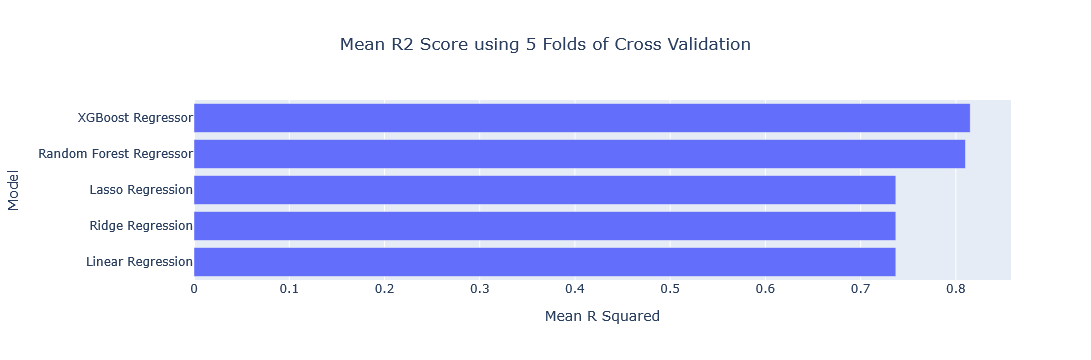

In [85]:
# Let's plot the r2_mean for each model
fig = px.bar(
    df_r2_scores.sort_values(by='r2_mean', ascending=True), 
    x='r2_mean', 
    y='model_name', 
    orientation='h', 
    title='Mean R2 Score using 5 Folds of Cross Validation'
)

fig.update_layout(
    xaxis_title='Mean R Squared',
    yaxis_title='Model',
    title_x=0.5
)

fig.update_traces(
    hovertemplate='%{label} has mean R-squared of %{value}'
)

fig.show()

* Random Forest and XGBoost regressors outperform Linear regression models.
* There is no significant difference between the performance of Random Forest and XGBoost.
* Let's calculate other metrics to compare the performance of RF and XGBoost regessor.

In [87]:
# Let's split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### __Random Forest Regressor vs XGBoost Regressor__

In [89]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
evaluate_model('Random Forest Regressor', y_test, rf_pred)

========== Random Forest Regressor ==========
R2: 0.800
Mean Absolute Error: 1136.436
Mean Squared Error: 4834157.634
Root Mean Squared Error: 2198.672


In [91]:
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
evaluate_model('XGBoost Regressor', y_test, xgb_pred)

========== XGBoost Regressor ==========
R2: 0.797
Mean Absolute Error: 1207.635
Mean Squared Error: 4917013.500
Root Mean Squared Error: 2217.434


* Based on the R-squared, MAE, MSE and RMSE, we can observe that the RF model has lower errors and a higher R-squared score compared to the XGBoost Regressor.
* So, we will select Random Forest Regressor as our model to make prediction about the monthly rental prices in Qatar for the month of Aug 2025.

#### __Retraining using the Entire dataset__

In [93]:
rf.fit(X, y)
y_pred = rf.predict(X)
evaluate_model('Random Forest Regressor (Final Model)', y, y_pred)

========== Random Forest Regressor (Final Model) ==========
R2: 0.923
Mean Absolute Error: 822.125
Mean Squared Error: 1631349.391
Root Mean Squared Error: 1277.243


## <span style="color:#CA6F1E;">12- Feature Importances</span>

Here, we visualize the top-10 feature that contribute the most to the model's predictions.

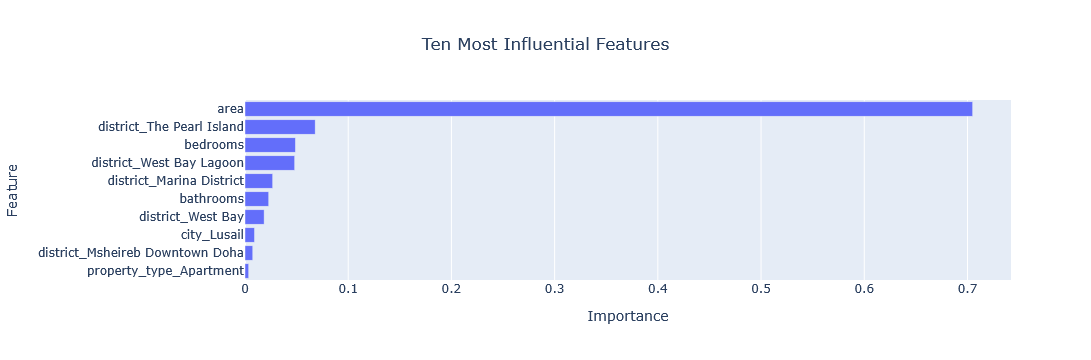

In [95]:
importances = rf.feature_importances_
df_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

# plot a bar chart of feature importances
fig = px.bar(
    df_feature_importances.head(10).sort_values(by='Importance', ascending=True), 
    x='Importance', 
    y='Feature', 
    orientation='h',
    title='Ten Most Influential Features',
)

fig.update_layout(title_x=0.5)
fig.update_traces(hovertemplate='%{label}: %{value}')

fig.show()

## <span style="color:#CA6F1E;">13- Making Predictions</span>

#### __Creating a Function to make predictions__

In [97]:
feature_columns = X.columns

def predict_rent_price(area, bedrooms, bathrooms, property_type, district, city, model):
    
    property_type = f'property_type_{property_type}'
    district = f'district_{district}'
    city = f'city_{city}'
    
    obs_dict = {feature: [0] for feature in feature_columns}
    obs_dict['area'][0] = area
    obs_dict['bedrooms'][0] = bedrooms
    obs_dict['bathrooms'][0] = bathrooms

    for cat_feature in [property_type, district, city]:
        if  cat_feature in obs_dict:
            obs_dict[cat_feature][0] = 1 

    df_obs = pd.DataFrame(obs_dict)
    
    pred = model.predict(df_obs).round(2)[0]
    
    return pred

#### __Making Predictions__

In [99]:
predict_rent_price(
    area=200, 
    bedrooms=4, 
    bathrooms=2, 
    property_type='Apartment', 
    district='Najma', 
    city='Doha',
    model=rf
)

10366.75

In [101]:
# Let's make predictions for the most popular or common listings in the Qatari market

area_median = df['area'].median()
bedrooms_median = df['bedrooms'].median()
bathrooms_median = df['bathrooms'].median()
common_property_type = df['property_type'].value_counts().idxmax()
common_city = df['city'].value_counts().idxmax()
common_district = df[df['city'] == common_city]['district'].value_counts().idxmax()

# Let's predict the monthly rental price for the most commong listing archetype
rent_pred = predict_rent_price(
    area=area_median, 
    bedrooms=bedrooms_median, 
    bathrooms=bathrooms_median, 
    property_type=common_property_type, 
    district=common_district, 
    city=common_city,
    model=rf
)

print(f"""
In the Qatari real estate market, the most common type of listing is an \033[1m{common_property_type}\033[0m, primarily located in \033[1m{common_district}\033[0m district of \033[1m{common_city}\033[0m.
The typical size of these listings is around \033[1m{area_median:.1f} sqm\033[0m, usually featuring \033[1m{bedrooms_median:.1f} bedrooms\033[0m and \033[1m{bathrooms_median:.1f} bathrooms\033[0m.
If you are looking to rent in Doha, you should be expecting to spend approximatley \033[1m{rent_pred:,.2f}\033[0m QAR per month.
""")


In the Qatari real estate market, the most common type of listing is an Apartment, primarily located in The Pearl Island district of Doha.
The typical size of these listings is around 125.0 sqm, usually featuring 2.0 bedrooms and 2.0 bathrooms.
If you are looking to rent in Doha, you should be expecting to spend approximatley 10,444.80 QAR per month.



## <span style="color:#CA6F1E;">14- Exporting Model</span>

#### __Export the Model to Pickle File__

In [103]:
with open('qatar_rental_price_model.pickle', 'wb') as bf:
    pickle.dump(rf, bf)

#### __Export Feature Names, Cities and Districtis to be used for our Prediction App__

In [105]:
features = X.columns.tolist()
property_types = df.property_type.unique().tolist()

model_info = {'features': features, 'property_types': property_types, 'cities': {}}

cities = df.city.unique().tolist()
for city in cities:
    districts = df[df.city == city].district.unique().tolist()
    model_info['cities'][city] = {'districts': districts}
    
with open('model_info.json', 'w') as jf:
    jf.write(json.dumps(model_info))